<a href="https://colab.research.google.com/github/ShrutiSaha03/Cardiovascular_Data_Acquisition-Disease_Detection_using_ML/blob/main/ML_part_Heart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout

In [4]:
# -----------------------------
# Parameters
# -----------------------------
FOLDER = "/content/drive/MyDrive/ml/set_a"  # Your folder path with all .wav files
SR = 1000               # Sampling rate
DURATION = 3            # Seconds
MAX_LEN = SR * DURATION
N_MELS = 64             # Mel bands
N_FFT = 256
HOP_LENGTH = 128

In [5]:
# -----------------------------
# Load and preprocess data using Mel Spectrogram
# -----------------------------
def extract_mel_spectrogram(signal, sr):
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db

In [6]:
def load_data(folder):
    X, y = [], []
    for fname in os.listdir(folder):
        if fname.endswith(".wav"):
            label = fname.split("_")[0].lower()
            path = os.path.join(folder, fname)

            signal, _ = librosa.load(path, sr=SR)
            if len(signal) < MAX_LEN:
                signal = np.pad(signal, (0, MAX_LEN - len(signal)))
            else:
                signal = signal[:MAX_LEN]

            mel_spec = extract_mel_spectrogram(signal, SR)
            X.append(mel_spec)
            y.append(label)

    return np.array(X), np.array(y)

In [7]:
x,y = load_data(FOLDER)

In [8]:
x

array([[[-35.1371   , -21.386215 , -24.689178 , ..., -27.379036 ,
         -19.556503 , -18.604065 ],
        [-37.78473  , -28.774452 , -28.783234 , ..., -21.853104 ,
         -17.13572  , -10.986671 ],
        [-33.938957 , -21.90561  , -22.147697 , ..., -17.899277 ,
         -12.014206 , -15.302605 ],
        ...,
        [-31.786316 , -15.768806 , -18.062347 , ..., -20.785904 ,
          -3.0690804,  -7.806549 ],
        [-36.45614  , -35.612183 , -25.182755 , ..., -27.533989 ,
         -14.976501 , -13.831158 ],
        [-43.79937  , -44.747414 , -44.77359  , ..., -42.22605  ,
         -38.75434  , -24.918358 ]],

       [[  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  

In [9]:
y

array(['artifact', 'artifact', 'artifact', 'artifact', 'artifact',
       'artifact', 'artifact', 'artifact', 'artifact', 'artifact',
       'artifact', 'artifact', 'artifact', 'artifact', 'artifact',
       'artifact', 'artifact', 'artifact', 'artifact', 'artifact',
       'artifact', 'artifact', 'artifact', 'artifact', 'artifact',
       'artifact', 'artifact', 'artifact', 'artifact', 'artifact',
       'artifact', 'artifact', 'artifact', 'artifact', 'artifact',
       'artifact', 'extrahls', 'artifact', 'artifact', 'extrahls',
       'extrahls', 'artifact', 'artifact', 'extrahls', 'extrahls',
       'extrahls', 'extrahls', 'extrahls', 'extrahls', 'extrahls',
       'extrahls', 'extrahls', 'murmur', 'extrahls', 'murmur', 'extrahls',
       'extrahls', 'murmur', 'extrahls', 'extrahls', 'murmur', 'murmur',
       'extrahls', 'extrahls', 'murmur', 'murmur', 'murmur', 'murmur',
       'murmur', 'murmur', 'murmur', 'murmur', 'murmur', 'murmur',
       'murmur', 'murmur', 'murmur', 'murmur

In [10]:
x.shape

(176, 64, 24)

In [11]:
y.shape

(176,)

In [12]:
# Convert Mel-Spectrograms to (samples, time, mel) for Conv1D
x = x.transpose((0, 2, 1))

In [13]:
encode=LabelEncoder()
y_encoded = encode.fit_transform(y)
y_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
# Encode labels
#convert the array value to binary data
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y) #Label encoding is a technique used to convert
#categorical data (like text) into a numerical format that machine learning models can understand.
#It assigns a unique integer to each distinct category
y_categorical = to_categorical(y_encoded)
y_categorical

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0.

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    x, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

In [16]:
print("total data size=",x.shape)
print("train data size=",X_train.shape)
print("test data size=",X_test.shape)

total data size= (176, 24, 64)
train data size= (140, 24, 64)
test data size= (36, 24, 64)


In [17]:
# -----------------------------
# CNN1D Model for Time-Frequency Features
# -----------------------------
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(32, 5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(X_train.shape[1:], num_classes=y_categorical.shape[1])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 64)          │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,437 (243.89 KB)

 Trainable params: 62,437 (243.89 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout

In [19]:
# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.1950 - loss: 10.3909 - val_accuracy: 0.4286 - val_loss: 2.9336
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3730 - loss: 4.5747 - val_accuracy: 0.3571 - val_loss: 3.2689
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2874 - loss: 2.5252 - val_accuracy: 0.4286 - val_loss: 1.4614
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3378 - loss: 1.8039 - val_accuracy: 0.6429 - val_loss: 1.3482
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3931 - loss: 1.6822 - val_accuracy: 0.5714 - val_loss: 1.6330
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4265 - loss: 1.4479 - val_accuracy: 0.4286 - val_loss: 1.5550
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4567 - loss: 1.3192 - val_accuracy: 0.5000 - val_loss: 1.4536
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4106 - loss: 1.2961 - val_accuracy: 0.5000 - val_loss: 1.4159
E

In [20]:
# Evaluate model
scores = model.evaluate(X_test, y_test)
print(scores)
print(f"\nTest Accuracy: {scores[1]*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step - accuracy: 0.6157 - loss: 1.1242
[1.1190524101257324, 0.6111111044883728]

Test Accuracy: 61.11%


In [21]:
# Predict single file
def predict_single(filepath):
    signal, _ = librosa.load(filepath, sr=SR)
    if len(signal) < MAX_LEN:
        signal = np.pad(signal, (0, MAX_LEN - len(signal))) #padding is done is the signal is less than MAX signal
    else:
        signal = signal[:MAX_LEN]

    mel_spec = extract_mel_spectrogram(signal, SR).T #T=transpose
    mel_spec = np.expand_dims(mel_spec, axis=0) #expand the signal due to maximum rows and column
    prediction = model.predict(mel_spec) #predicction done
    predicted_label = encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Example:
# print(predict_single("HeartSounds/abnormal_201105060608.wav"))
print(predict_single("/content/drive/MyDrive/Copy of Aunlabelledtest__201108222244.wav"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
murmur


In [23]:
#predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([0, 4, 0, 1, 0, 4, 1, 4, 0, 4, 0, 0, 4, 4, 1, 3, 1, 3, 0, 4, 1, 4,
       2, 1, 3, 1, 4, 4, 4, 3, 3, 1, 1, 1, 4, 1])

In [24]:
y_true_classes = np.argmax(y_test, axis=1)
y_true_classes

array([0, 3, 0, 1, 0, 2, 3, 4, 0, 1, 1, 1, 4, 4, 1, 3, 0, 3, 0, 4, 0, 1,
       1, 1, 3, 2, 4, 2, 4, 3, 3, 1, 1, 1, 2, 0])

In [25]:
# Classification report
#it helps to state the accuracy by providing the probability of different classes
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))


Classification Report:
                 precision    recall  f1-score   support

       artifact       0.71      0.62      0.67         8
aunlabelledtest       0.55      0.55      0.55        11
       extrahls       0.00      0.00      0.00         4
         murmur       1.00      0.71      0.83         7
         normal       0.50      1.00      0.67         6

       accuracy                           0.61        36
      macro avg       0.55      0.58      0.54        36
   weighted avg       0.60      0.61      0.59        36



In [26]:
# Confution matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm

array([[5, 3, 0, 0, 0],
       [2, 6, 1, 0, 2],
       [0, 1, 0, 0, 3],
       [0, 1, 0, 5, 1],
       [0, 0, 0, 0, 6]])

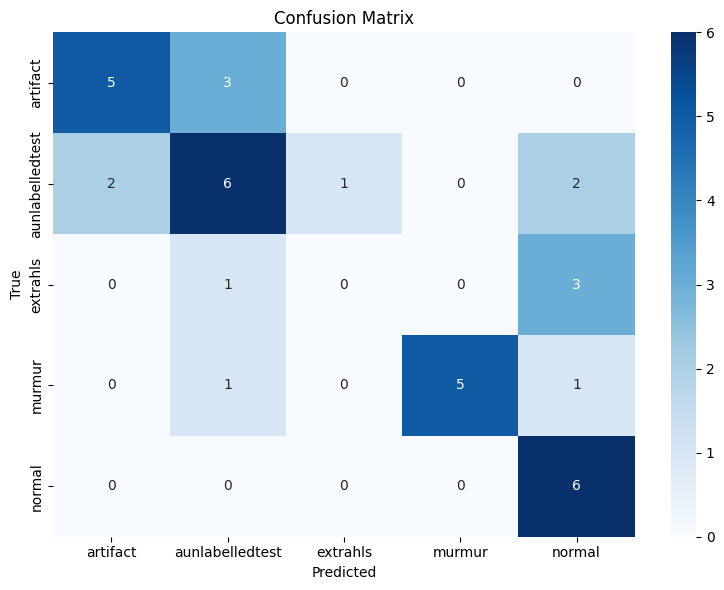

In [28]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [29]:
y_categorical.shape

(176, 5)